In [13]:
import sys
import cv2
sys.path.insert(1, '../../src/')
import matplotlib.pyplot as plt
from models.rtmpose.model import RTMPoseModel
from rtmlib import draw_skeleton
import copy 

In [15]:
kpt_thr = 6
model = RTMPoseModel(filtering=False,mode='robust',backend='onnxruntime',threshold=kpt_thr)

import time
import traceback
import numpy as np

# define a video capture object 
vid = cv2.VideoCapture("/media/cristian/12FF1F6D0CD48422/Research/Gloss/Gloss/Datasets/wlasl-complete/videos/17165.mp4")#68508.mp4")#54563.mp4")#68914.mp4") 

#vid = cv2.VideoCapture(0)
cv2.namedWindow("frame", cv2.WINDOW_NORMAL) 

list_keypoints = []
list_scores = []
cnt = 0

while(True): 
    
    ret, frame = vid.read() 
    if ret is None or frame is None:
        break
    
    frame = cv2.resize(frame,(640,480))
    
    try:
        frame_rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

        keypoints, scores  = model.predict(frame_rgb)
        list_keypoints.append(keypoints[0,:,:])
        list_scores.append(scores[0,:])


        frame_original = draw_skeleton(copy.deepcopy(frame), keypoints, scores, kpt_thr=kpt_thr,
                                    line_width=1,radius=1)
        
       
        score_value = np.round(scores[0,91],2)

        frame = draw_skeleton(frame, keypoints, scores, kpt_thr=kpt_thr,
                                    line_width=1,radius=1)

        cnt+=1
        vis1 = np.concatenate((frame_original,frame), axis=1)
        
        key_p1 = np.round(keypoints[0,91,0],2)
        key_p2 = np.round(keypoints[0,91,1],2)

        vis1 = cv2.putText(vis1, f'i={cnt},s={str(score_value)[:4]},k={str(key_p1)[:6]},{str(key_p2)[:6]}', (10, 10) , 
                            cv2.FONT_HERSHEY_SIMPLEX ,  
                        0.4, (255, 0, 0) , 1, cv2.LINE_AA) 
        
        cv2.imshow('frame', vis1) 
        #cv2.waitKey()
        
        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break
    except:
        print(traceback.format_exc())
        break
    
    #time.sleep(1)

# After the loop release the cap object 
vid.release() 
# Destroy all the windows 
cv2.destroyAllWindows() 


onnx_model: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/onnx_sdk/yolox_m_8xb8-300e_humanart-c2c7a14a.zip
onnx_model: /home/cristian/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx
load /home/cristian/.cache/rtmlib/hub/checkpoints/yolox_m_8xb8-300e_humanart-c2c7a14a.onnx with onnxruntime backend
onnx_model: /media/cristian/12FF1F6D0CD48422/Research/Gloss/Gloss/Pruebas_antiguas/RTMPOSE/juxtapose/model/rtmpose-x.onnx
onnx_model: /media/cristian/12FF1F6D0CD48422/Research/Gloss/Gloss/Pruebas_antiguas/RTMPOSE/juxtapose/model/rtmpose-x.onnx


2024-05-11 17:07:27.478236194 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-05-11 17:07:27.478254663 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.
2024-05-11 17:07:27.698946213 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-05-11 17:07:27.698962097 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


load /media/cristian/12FF1F6D0CD48422/Research/Gloss/Gloss/Pruebas_antiguas/RTMPOSE/juxtapose/model/rtmpose-x.onnx with onnxruntime backend


In [16]:
list_keypoints = np.array(list_keypoints)
list_scores = np.array(list_scores)
list_keypoints.shape,list_scores.shape

((94, 133, 2), (94, 133))

In [131]:
import cv2
import numpy as np
from padasip.filters import AdaptiveFilter,FilterNLMS

def initialize_adaptive_filter(num_keypoints):
    filters = []
    for _ in range(num_keypoints):
        #filter_x = AdaptiveFilter(n=1, mu=0.00005, w="zeros")
        #filter_y = AdaptiveFilter(n=1, mu=0.00005, w="zeros")
        
        filter_x = FilterNLMS(1, mu=0.9)
        filter_y = FilterNLMS(1, mu=0.9)


        filters.append((filter_x, filter_y))
    return filters

def track_keypoints(t,keypoints,scores, adaptive_filters):
    keypoints_pred = np.zeros_like(keypoints)
    for i, keypoint in enumerate(keypoints):
        filter_x, filter_y = adaptive_filters[i]
        #if keypoint[0] == 0 and keypoint[1] == 0:
        #print(t,keypoint[0])

        predicted_x = filter_x.predict(x=np.array([t]))
        predicted_y = filter_y.predict(x=np.array([t]))

        filter_x.adapt(x=np.array([t]), d=keypoint[0])
        filter_y.adapt(x=np.array([t]), d=keypoint[1])
        
        #print("predicted_x:",predicted_x)
        keypoints_pred[i] = [predicted_x, predicted_y]
        """
        if scores[i]<5.5:
            # Si el keypoint es 0, utilizar la predicción del filtro adaptativo
            keypoints_pred[i] = [predicted_x, predicted_y]
        else:
            # Si el keypoint es válido, actualizar el filtro adaptativo
            keypoints_pred[i] = [keypoint[0],keypoint[1]]
        """
    return keypoints_pred

# Inicializar los filtros adaptativos para cada keypoint
num_keypoints = 1  # o 266
adaptive_filters = initialize_adaptive_filter(num_keypoints)

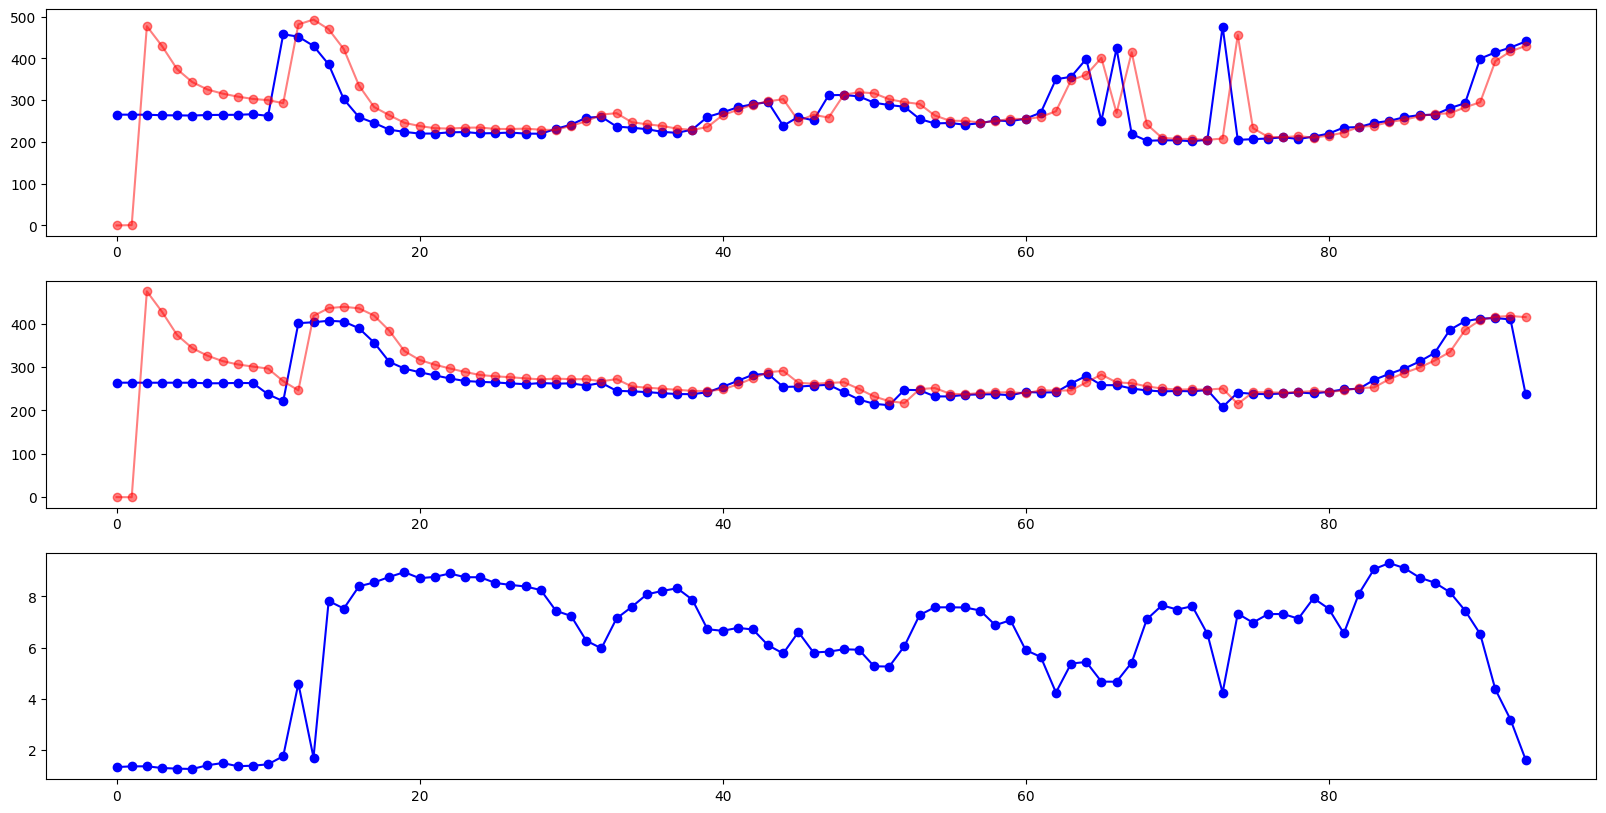

In [132]:
id = 101
points_x        = list_keypoints[:,id,0] 
points_y        = list_keypoints[:,id,1]
scores_points = list_scores[:,id]

points_x_pred = np.zeros_like(points_x)
points_y_pred = np.zeros_like(points_y)

for i in range(len(points_x)):
    keyp_aux   = [[points_x[i],points_y[i]]]
    scores_aux = [scores_points[i]]
    tracked_keypoints = track_keypoints(i,keyp_aux,scores_aux, adaptive_filters)
    points_x_pred[i] = tracked_keypoints[0][0]
    points_y_pred[i] = tracked_keypoints[0][1]
fig = plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(points_x,'-ob')
plt.plot(points_x_pred,'-or',alpha=0.5)
plt.subplot(3,1,2)
plt.plot(points_y,'-ob')
plt.plot(points_y_pred,'-or',alpha=0.5)
plt.subplot(3,1,3)
plt.plot(scores_points,'-ob')
#plt.plot(scores_points_new,'-og',alpha=0.2)
plt.show()